## Classification Model Testing
These are the different classification models that we are going to work with:
- **SVC** ( Support Vector Machine )
- **LogisticalRegression**
- **NN** ( Neural Network )
- **CNN** ( Convolutional Neural Network)

For the two first models, we will use every evaluation model to test the results. For the last two, we only will use $holdout$. These are the 3 evaluation models that we are going to test:
- **Holdout**
- **Resubstitution**
- **Cross-Validation**

To test the classification models, we need to apply the following metrics. For $holdout$ and $resubstitution$ we used:
- From the *classification_report* function:
  - **Precision**
  - **Recall**
  - **F1-Score**
  - **Samples**
- **Roc_Auc_Score**
- **Accuracy_Score**
To test the $cross$-$validation$ models, we used these ones:
- **Recall**
- **Precision**
- **Accuracy**
- **F1-macro**
- **Recall_macro**
- **Precision_macro**
- **F1-weighted**
- **Recall_weighted**
- **Precision_weighted**

---

##  Metrics
Now we will explain briefly each metric:

### **Precision**
The true positive $(TP)$ over every positive $(TP+FP)$

### **Recall**
The true positive $(TP)$ over every real positive $(TP+FN)$
The recall is the metric that owes the capability of the classifier model to predict correctly the positive class

### **F1-Score**
Armonic mean between $precision$ and $recall$
We use this metric when we have unbalanced data

### **ROC-AUR**
Area under the ROC curve
This metric show the capability of a classifier model to distinguish between positive and negative classes moving. 
A high value indicates out classifier has a good chance of being correct

### **Accuracy** 
Correct prediction $(TP+FN)$ over every prediction $(FP+FN+TP+TN)$

---

## Evaluation Method
Now we will explain briefly how the different evaluation method works:

### **Holdout** 
- We split the data into training (1) and testing (2)
- We train the model with (1) and make predictions with (2)
- It's the most common evaluation method when we want to make easily preictions

### **Resubstitution** 
- We use the same dataset for training and testing
- We do the metrics using the same data used for trainig and testing
- It's an optimistic evaluation of a model because we overfit the model when we use the same data to train and test.
- It can only shows us how the method learn the training data

### **Cross-Validation** 
- We split the data in (k) same length partition 
- We train the model (k) times using (k-1) partitions as training data and the rest as testing data
- It's a more realistic evaluation of a model because we don't overfit the model when we use the same data to train and test.

In [2]:
# Basic Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# Dataset and Train-Test function
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_validate

# Preprocessing
from sklearn.preprocessing import LabelEncoder

# Classifactions sklearn
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, roc_curve, auc, f1_score

# Classification Keras + Tensorflow + Torch
import torch 
import torch.utils
import torch.nn as nn 
import torch.utils.data
import tensorflow as tf
import torch.optim as optim 
import torchvision.models as models
from tensorflow.keras import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

import seaborn

def plot_roc(y_test, y_scores):
    # Compute ROC curve and ROC area
    fpr, tpr, thresholds = roc_curve(y_test==1, y_scores)
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(y_test, y_pred, classes):
    # Calculate confusion matrix
    cm = confusion_matrix(y_test==1, y_pred)

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

def print_metrics(y_test, y_pred): 
    print(f'Results:\nClassification-Report:\n{classification_report(y_test==1, y_pred)}')
    print(f'\nConfusion-Matrix: \n{confusion_matrix(y_test==1, y_pred)}')
    print(f'\nROC-AUC-Score: \n{roc_auc_score(y_test==1, y_pred):.4f}')  
    print(f'\nAccuracy-Score: \n{accuracy_score(y_test==1, y_pred):.4f}')


def plot_all(y_test, y_scores, y_pred, classes):
    plot_roc(y_test, y_scores)
    plot_confusion_matrix(y_test, y_pred, classes)
    print_metrics(y_test, y_pred)

def print_cross_validation_metrics(model, X, y, cv=5):
    SCORING = ('f1', 'recall', 'precision', 'accuracy', 'f1_macro', 'recall_macro', 'precision_macro', 'f1_weighted', 'recall_weighted', 'precision_weighted')
    scores = cross_val_score(model, X, y==1, cv=cv)
    scores_dict = cross_validate(model, X, y==1, cv=cv, scoring=SCORING)

    for key in SCORING:
        print(f"{key:>20} : {scores_dict[f'test_{key}'].mean()}")

##### Load Dataset

In [3]:
lfw_people = fetch_lfw_people(min_faces_per_person=53, resize=.4)
X, y = lfw_people.images, lfw_people.target

print("Shapes:")
print(f"\tX or images vector: {X.shape}")
print(f"\tY or target vector: {y.shape}")

Shapes:
	X or images vector: (1456, 50, 37)
	Y or target vector: (1456,)


The shape show us that we have a dataset with 1456 images with a 50x37 pixel resolution

##### Positive-Negative Image

Text(0.5, 1.0, 'Negative class Image')

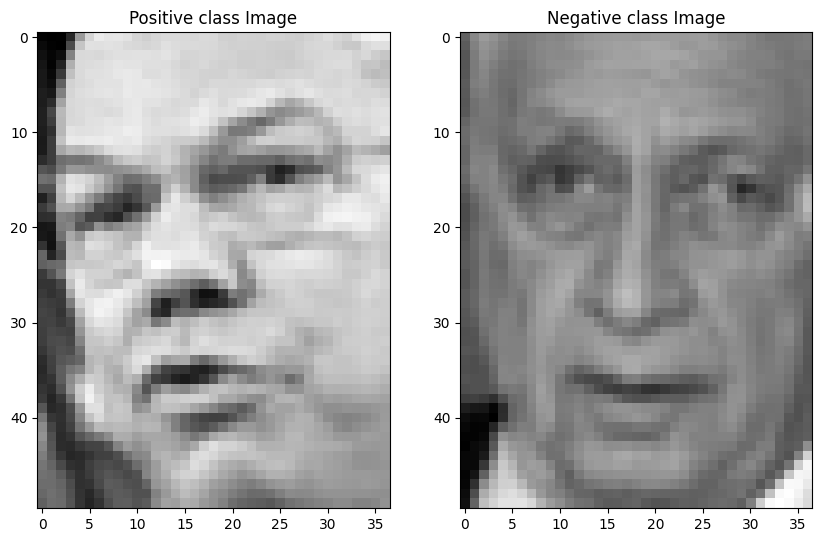

In [4]:
# Plot a positive and negative image for classifications purposes
plt.figure(figsize=(10,10))
# Positive
plt.subplot(1,2,1)
plt.imshow(X[y==1][0], cmap='gray')
plt.title('Positive class Image')
# Negative
plt.subplot(1,2,2)
plt.imshow(X[y==0][0], cmap='gray')
plt.title('Negative class Image')

In [5]:
# This will show us if we are ir [0,1] range or [0, 255]
print(f"Range of values in each pixel: {np.min(X), np.max(X)}")

print(f"Classes: {lfw_people.target_names.shape[0]}")

Range of values in each pixel: (0.0, 1.0)
Classes: 10


### First dataset implementations

#### Data preprocessing

For this step we will just use a Label encoder to create the Y labels fot the classification methods

In [6]:
X_reshape = X.reshape((X.shape[0], -1 )) # Flatten image

labelEncoder = LabelEncoder()
y_encoded = labelEncoder.fit_transform(y)
X_reshape.shape, y_encoded.shape

((1456, 1850), (1456,))

#### Split the dataset

We split the dataset into training and testing to make the holdout evaluation method.

For the other two evaluation methos we will use X_train and y_train in both cases.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_reshape, y_encoded, test_size=.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1164, 1850), (292, 1850), (1164,), (292,))

## Linear and Quadratic

Total dataset size:
n_samples: 1560
n_features: 1850
n_classes: 12
how many 1 are in sample: 236


c:\Users\algar\Desktop\UV\UV_GII4_2023_2024\Data Mining & Machine Learning\DMandML\venv\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\algar\Desktop\UV\UV_GII4_2023_2024\Data Mining & Machine Learning\DMandML\venv\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\algar\Desktop\UV\UV_GII4_2023_2024\Data Mining & Machine Learning\DMandML\venv\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\algar\Desktop\UV\UV_GII4_2023_2024\Data Mining & Machine Learning\DMandML\venv\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\algar\Desktop\UV\UV_GII4_2023_2024\Data Mining & Machine Learning\DMandML\venv\lib\site-package

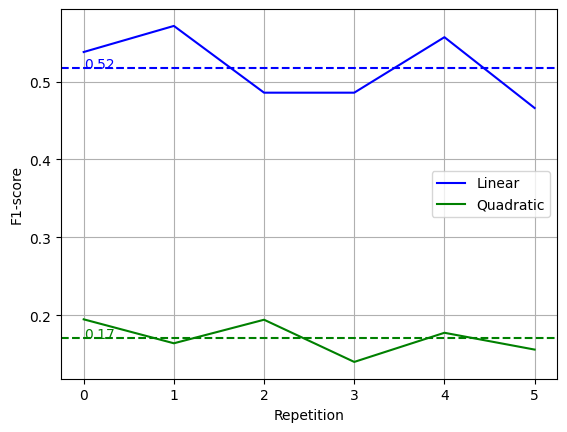

In [8]:
faces_dataset = fetch_lfw_people(min_faces_per_person=50, resize=.4)
n_samples, h, w = faces_dataset.images.shape
names = faces_dataset.target_names

X, Y = faces_dataset.data, faces_dataset.target
print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % X.shape[1])
print("n_classes: %d" % faces_dataset.target_names.shape[0])
print(f"how many 1 are in sample: {np.unique(Y, return_counts=True)[1][1]}")


linear_f1_score_list = []
quadratic_f1_score_list = []
REPETITIONS = range(0,6,1)

for i in REPETITIONS:
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.25)

    linear = LinearDiscriminantAnalysis()
    quadratic = QuadraticDiscriminantAnalysis()

    linear.fit(X_train, Y_train==1)
    quadratic.fit(X_train, Y_train==1)

    linear_pred = linear.predict(X_test)
    quadratic_pred = quadratic.predict(X_test)

    linear_f1_score_list.append( f1_score(Y_test==1, linear_pred==1) )
    quadratic_f1_score_list.append( f1_score(Y_test==1, quadratic_pred==1) )


plt.plot(REPETITIONS, linear_f1_score_list, color='blue', label="Linear")
plt.axhline(y=np.mean(linear_f1_score_list), linestyle='dashed', color='blue')
plt.text(0, np.mean(linear_f1_score_list), f"{np.mean(linear_f1_score_list):.2f}", color='blue')

plt.plot(REPETITIONS, quadratic_f1_score_list, color='green', label="Quadratic")
plt.axhline(y=np.mean(quadratic_f1_score_list), linestyle='dashed', color='green')
plt.text(0, np.mean(quadratic_f1_score_list), f"{np.mean(quadratic_f1_score_list):.2f}", color='green')

plt.xlabel("Repetition")
plt.ylabel("F1-score")
plt.legend()
plt.grid()
plt.show()



## KNN

In [ ]:
NEIGHBORS = range(1,26)
REPETITIONS = range(0, 6)

f1_scores = [[] for _ in REPETITIONS]
for i in REPETITIONS:
    for nei in NEIGHBORS:
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.25)
        classi = KNeighborsClassifier(n_neighbors=nei)
        classi.fit(X_train, Y_train==1)
        Y_predict = classi.predict(X_test)

        f1_scores[i].append( f1_score(Y_test==1, Y_predict==1) )
        print(Y_predict)

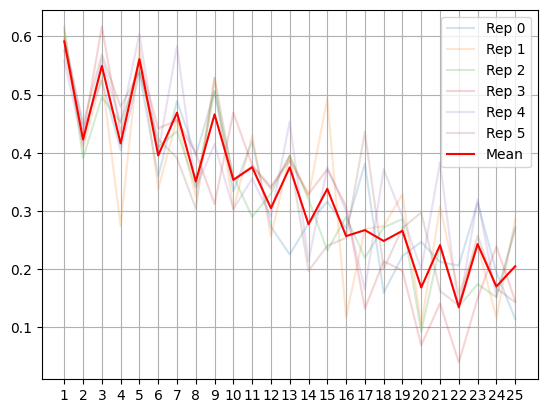

In [10]:
for i, scores in enumerate(f1_scores):
    plt.plot(NEIGHBORS, scores, alpha=0.2, color=f"C{i}", label=f"Rep {i}")

plt.plot(NEIGHBORS, np.mean(f1_scores, axis=0), color='red', label="Mean")
plt.xticks(NEIGHBORS)
plt.grid()
plt.legend()
plt.show()

## MPI

In [19]:
# Define the range of neurons for each layer
NEURONS = range(1, 26, 5)

# Prepare an array to store F1 scores
f1_scores = np.zeros((len(NEURONS), len(NEURONS)))

# Grid search over neuron configurations
for i, n1 in enumerate(NEURONS):
    for j, n2 in enumerate(NEURONS):
        # Define and train the MLP classifier
        mlp = MLPClassifier(hidden_layer_sizes=(n1, n2), max_iter=1000)
        mlp.fit(X_train, Y_train==1)
        
        # Predict and compute F1 score
        y_pred = mlp.predict(X_test)
        score = f1_score(Y_test==1, y_pred)
        f1_scores[i, j] = score

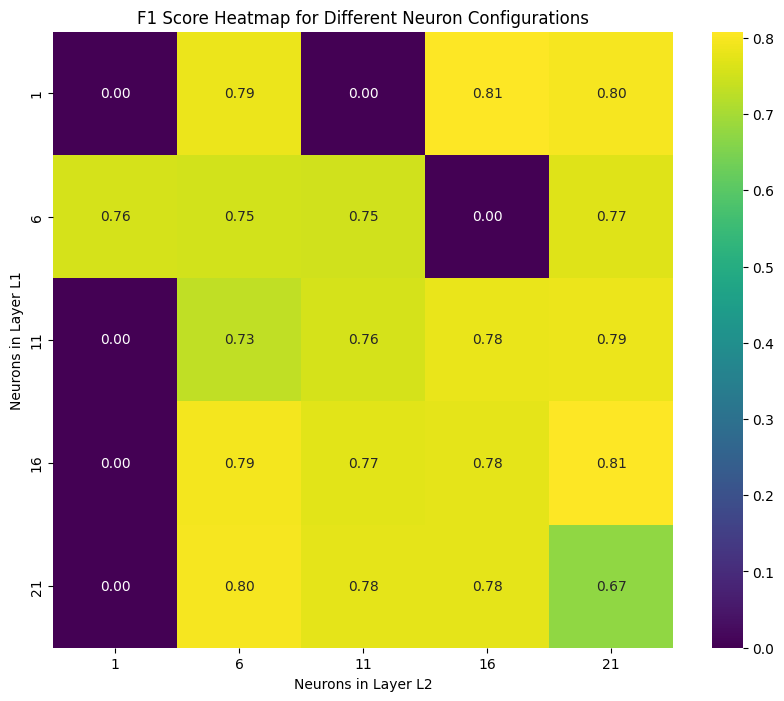

In [20]:
# Plotting the heatmap
plt.figure(figsize=(10, 8))
seaborn.heatmap(f1_scores, annot=True, cmap='viridis', xticklabels=NEURONS, yticklabels=NEURONS, fmt=".2f")
plt.xlabel('Neurons in Layer L2')
plt.ylabel('Neurons in Layer L1')
plt.title('F1 Score Heatmap for Different Neuron Configurations')
plt.show()

## SVC ( Support Vector Machines )

The SVM are supervised training algorithms for classification and regression. They try to find the best hyperplane that split the principal space components.

How they work:

- Hyperplane selection: 
    - The SVM find the best hyperplane which has the best score
    - The optimal hyperplane is the one with the higher distance betweem the hyperplane and the data points closest to each class.
- Features transformation:
    - If the dataset is not linear in the original space, we can apply a non linear transformation, transforming the data into a bigger space where they will be linear.
- Loss function and optimization:
    - The SVM uses a a hinge-loss function. This function penalize the missclassification and maximize the margin between clases.
    - To optimize the minimum loss-function that maximizes the margin, we formule an optimization convex function.

### Holdout

#### Searching the optimal Classifier

We are going to use a grid search to find the best hyperparameters for the SVM classifier using th f1-score.

In [86]:
# Starting from the kernel type
model = SVC(probability=True) # We set the random state to be able to repeat the model
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
colores = ['red', 'green', 'blue', 'purple']
probabilities = []
for kernel in kernels:
    model.set_params(kernel=kernel)
    model.fit(X_train, y_train==1)
    probabilities.append(f1_score(y_test==1, model.predict(X_test)))
probabilities

[0.7789473684210526, 0.8041237113402062, 0.7733333333333333, 0.0]

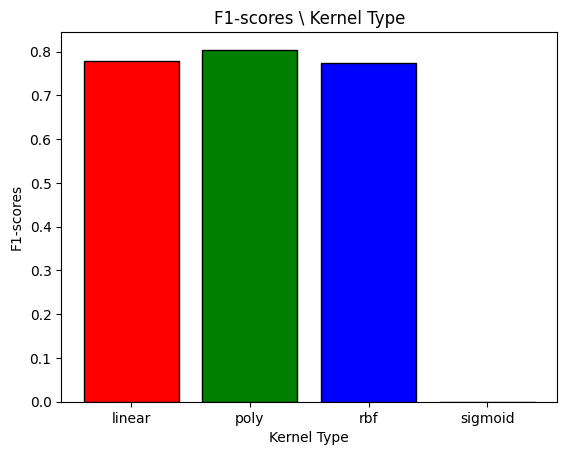

In [87]:
plt.bar(kernels, probabilities, color=colores, edgecolor='black')
plt.xlabel('Kernel Type')
plt.ylabel('F1-scores')
plt.title('F1-scores \ Kernel Type')
plt.show()

As we can see here in our study, the 'poly' kernel is the best for our dataset, now we will study another hyperparameter for 'poly' one

In [88]:
# We study the degree
model = SVC(kernel='poly', probability=True, random_state=42)
degrees = [2, 3, 4, 5 ]
colores = ['red', 'green', 'blue', 'purple']
probabilities = []
for degree in degrees:
    model.set_params(degree=degree)
    model.fit(X_train, y_train==1)
    probabilities.append(f1_score(y_test==1, model.predict(X_test)))
probabilities

[0.8387096774193549,
 0.8041237113402062,
 0.7835051546391752,
 0.7835051546391752]

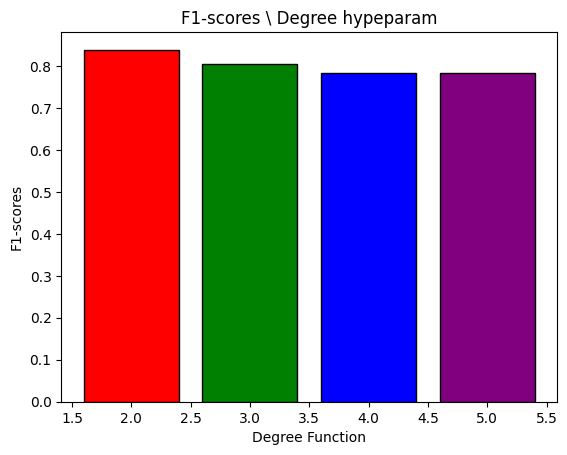

In [89]:
plt.bar(degrees, probabilities, color=colores, edgecolor='black')
plt.xlabel('Degree Function')
plt.ylabel('F1-scores')
plt.title('F1-scores \ Degree hypeparam')
plt.show()

As we can see, the second degree function is the best in comparison to the rest.

In [90]:
svm_classifier = SVC(kernel='poly', degree=2,  probability=True, random_state=42)

svm_classifier.fit(X_train, (y_train==1))

SVC(degree=2, kernel='poly', probability=True, random_state=42)

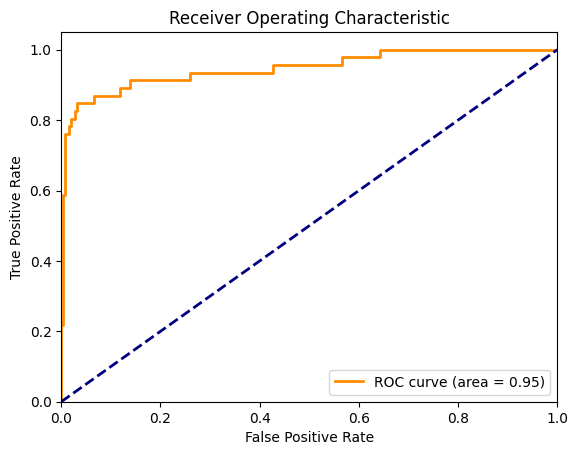

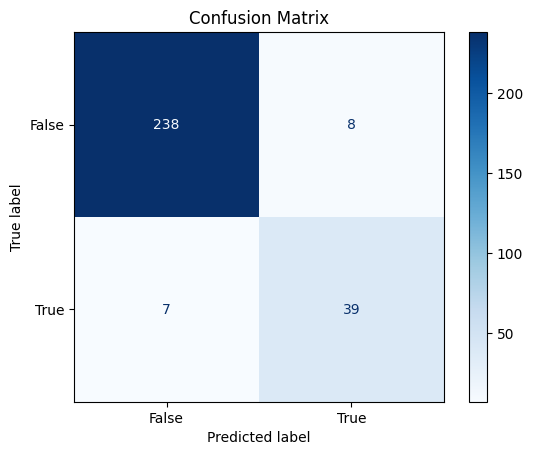

Results:
Classification-Report:
              precision    recall  f1-score   support

       False       0.97      0.97      0.97       246
        True       0.83      0.85      0.84        46

    accuracy                           0.95       292
   macro avg       0.90      0.91      0.90       292
weighted avg       0.95      0.95      0.95       292


Confusion-Matrix: 
[[238   8]
 [  7  39]]

ROC-AUC-Score: 
0.9077

Accuracy-Score: 
0.9486


In [91]:
y_scores = svm_classifier.predict_proba(X_test)[:,1]
y_pred = svm_classifier.predict(X_test)

plot_all(y_test, y_scores, y_pred, svm_classifier.classes_)

#### <label style='color:red'>Explanation</label>

We all can see two graphics, one with the ROC curve of the classifier with a very good AUC score (0.94). This value says that our classifier has the capability of classifiy correctly the 94% of the incoming data.

The second graphic is a visual representation of a Confusion Matrix where we can see that our classifier predict correctly 234 True values and 37 negative values and only missclassified 12 for positives and 9 for negatives which is a very good value.

After that, we can see a classification report that shows us 4 different values, the precission, recall, f1-score and the number of samples in each class. We also see the average and the weighted average of these metrics.
In this case, our classifier has a precision of 0.96 and 0.76 respectively, this shows us that our classifier knows that the .96 of the false classes are truly false and the 0.76 of the true ones are really true.
The recall show if the classifier is classifying correctly or if it's missclassifying. Our classifier has a 0.95 in negative class and a 0.80 in positive class.

The f1-score is an armonic mean between precision and recall so we do not talk about it

The support is the number of training data for each class

The accuracy score shows how many data are classified correctly. Our classifier predict well a 0.92

### Resubstitution

In [92]:
svm_classifier = SVC(kernel='poly',degree=2,  probability=True, random_state=42)

svm_classifier.fit(X_train, (y_train==1))

SVC(degree=2, kernel='poly', probability=True, random_state=42)

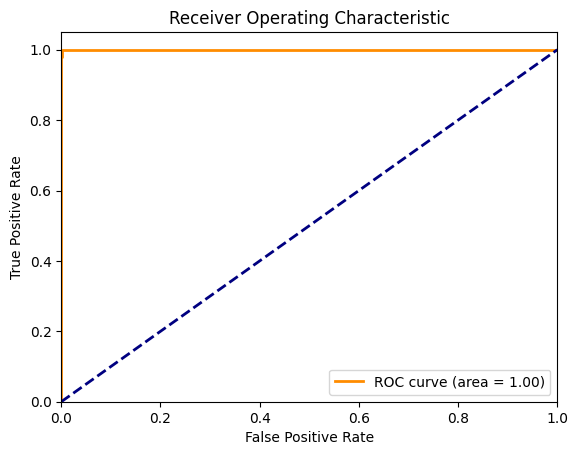

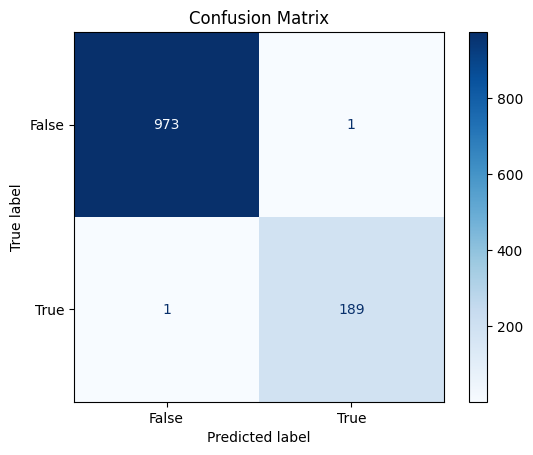

Results:
Classification-Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       974
        True       0.99      0.99      0.99       190

    accuracy                           1.00      1164
   macro avg       1.00      1.00      1.00      1164
weighted avg       1.00      1.00      1.00      1164


Confusion-Matrix: 
[[973   1]
 [  1 189]]

ROC-AUC-Score: 
0.9969

Accuracy-Score: 
0.9983


In [93]:


y_scores = svm_classifier.predict_proba(X_train)[:,1]
y_pred = svm_classifier.predict(X_train)

plot_all(y_train, y_scores, y_pred, svm_classifier.classes_)


The result show what we were expecting, when u use a resubstitution method for a classifier you are truly training and testing with the same data so your'r classifier, if it's well-trained, shouldn't make miss-classified predictions. That's why we have a perfect data in the reports.

#### Cross-Validation

In [94]:
svm_classifier = SVC(kernel='poly',degree=2, probability=True, random_state=42)
# SCORING = ('f1', 'recall', 'precision', 'accuracy', 'f1_macro', 'recall_macro', 'precision_macro', 'f1_weighted', 'recall_weighted', 'precision_weighted')

scores = cross_val_score(svm_classifier, X_reshape, y==1, cv=5)
# scores_dict = cross_validate(svm_classifier, X_reshape, y==1, cv=5, scoring=SCORING)

# for key in SCORING:
#     print(f"{key:>20} : {scores_dict[f'test_{key}'].mean()}")

print_cross_validation_metrics(svm_classifier, X_reshape, y==1)

                  f1 : 0.7987500806746552
              recall : 0.7754432624113475
           precision : 0.8255667972689249
            accuracy : 0.9368121263475027
            f1_macro : 0.8806321352610433
        recall_macro : 0.8717380246482967
     precision_macro : 0.8913472547100557
         f1_weighted : 0.93597296339024
     recall_weighted : 0.9368121263475027
  precision_weighted : 0.9358131483410048


In [95]:
np.max(scores), np.min(scores), np.average(scores), np.mean(scores)

(0.9450171821305842,
 0.9175257731958762,
 0.9368121263475027,
 0.9368121263475027)

When using the cross-validation method, you repeat the same training (k) times and the make a mean or average of the (k) scores. That's why we can see a little improve in the performance. Instead of a ROC plot or a confusion matrix plot, we have the metrics in raw text format

## Logistic Regression 
La regresion Logística es un algoritmo de aprenizaje supervisado utilizado principalmente para la clasificación binaria, aunque puede extenderse a la clasificación multiclase con algoritmos como regresión multinominal.

Funciona así:

- Modelo matemático : 
    - Utiliza la función logística ( sigmoide ) para modelar la probabilidad de que una instancia pertenezca a una  clase en particular
    - Esta función transforma cualquier valor al rango [0,1]
- Entrenamiento del modelo : 
    - Durante el entrenamiento, este ajusta el los parámetros del modelo para maximizar la verosimilitud de los datos obsevador.
    - Esto implica ajustar los parámetros del modelo de manera que la probabilidad de observar las etiquetas de clase reales dados los datos de entrada sea máxima
- Función de costo : 
    - La función de costo más comunmente utilizada es la 'binary cross-entropy'
    - Esta función penaliza las predicciones incorrectas de manera proporcional a la diferencia entre la probabilidad predicha y la verdadera
- Predicción : 
    - Una vez entrenado el modelo, se utiliza para predecir la probabilidad de que una nueva instancia pertenezca a cada clases
    - Si la probabilidad predicha es mayor que 0.5, entonces la instancia se clasifica como perteneciente a la clase positiva

### Holdout

##### Hiperparameter study

In [107]:
# First of all, we will study the 'c' hiperparam
model = LogisticRegression()
c_values = [0.001, 0.01, 0.1, 1, 10]
print(len(c_values))
colores = ['red', 'green', 'blue', 'purple', 'brown']
scores = []
for c in c_values:
    model.set_params(C=c)
    model.fit(X_train, (y_train==1))
    scores.append(f1_score(y_test==1, model.predict(X_test)))
print(f'Best score: {np.max(scores)} ({np.argmax(scores)})')

5
Best score: 0.8444444444444444 (3)


x:\Repos\DMandML\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


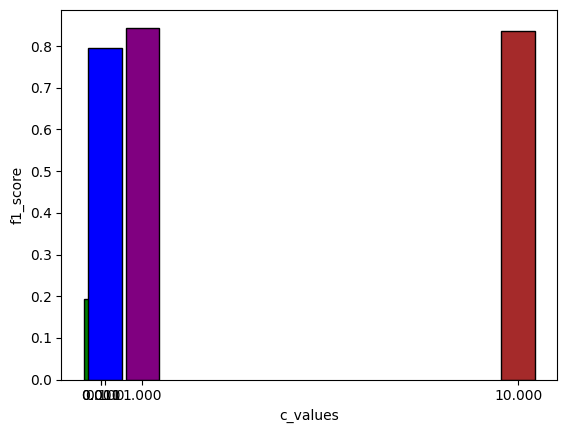

In [111]:
plt.bar(c_values, scores, color=colores ,edgecolor='black')
plt.xlabel('c_values')
plt.ylabel('f1_score')
plt.xticks(c_values)
plt.show()

The optimum inverse regularization is the third component of the c_values

In [105]:
logisticClassifier = LogisticRegression()

logisticClassifier.fit(X_train, (y_train==1))

LogisticRegression()

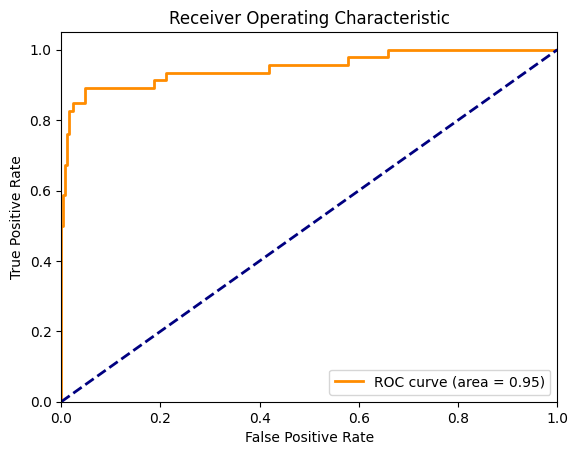

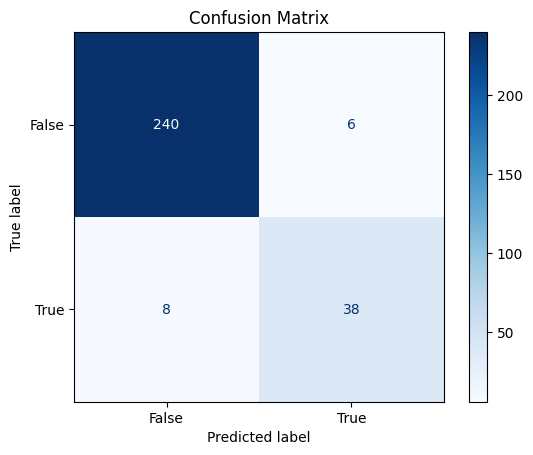

Results:
Classification-Report:
              precision    recall  f1-score   support

       False       0.97      0.98      0.97       246
        True       0.86      0.83      0.84        46

    accuracy                           0.95       292
   macro avg       0.92      0.90      0.91       292
weighted avg       0.95      0.95      0.95       292


Confusion-Matrix: 
[[240   6]
 [  8  38]]

ROC-AUC-Score: 
0.9008

Accuracy-Score: 
0.9521


In [106]:
y_pred = logisticClassifier.predict(X_test)
y_scores = logisticClassifier.predict_proba(X_test)[:,1]

plot_all(y_test, y_scores, y_pred, logisticClassifier.classes_)

#### <label style='color:red'>Explicación de resultados</label>
- Precision : 
    - Es la proporción de instancias clasificadas como positivas que son verdaderamente positivas.
    - En este caso tenemos que l 97% de las instancias negativas son verdaderamente negativas y el 86% de las positivas son realmente positivas.
- Recall : 
    - Es la proporción de instancias positivas que han sido clasificadas como positivas.
    - En este caso el 98% de las clasificadas como negativas eran verdaderamente negativas mientras que de las positivas, el 83% de las positivas eran verdaderamente positivas
- F1-Score :
    - Media armónica entre precisión y recall.
- Support :
    - Número de casos de entrenamiento de cada clase
- Matriz de confusión :
    - En este caso, la clase False se predijo correctamente en 240 casos, mientras que 6 instancias verdaderamente False se clasificaron incorrectamente como True. Para la clase True, 38 instancias verdaderamente True se clasificaron correctamente, mientras que 8 instancias verdaderamente False se clasificaron incorrectamente como False
- ROC_AUC score : 
    - En este caso, el 90.08% es un buen valor que nos indica el rendimiento del modelo para distinguir entre clases.
- Accuracy score: 
    - En este caso, como tenemos un 95.20% nos indica que de todas las muestras, más del 95% han sido clasificadas correctamente

#### Resubstitution

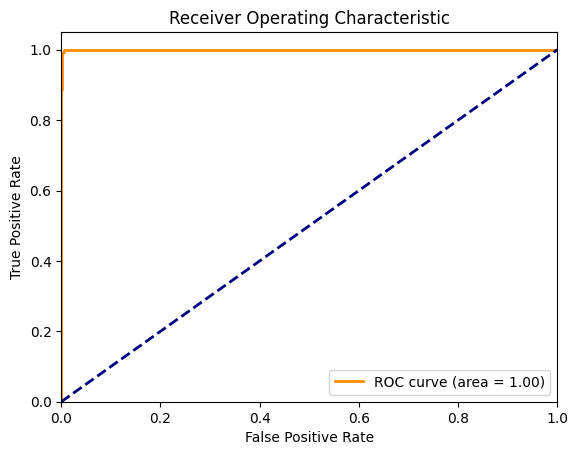

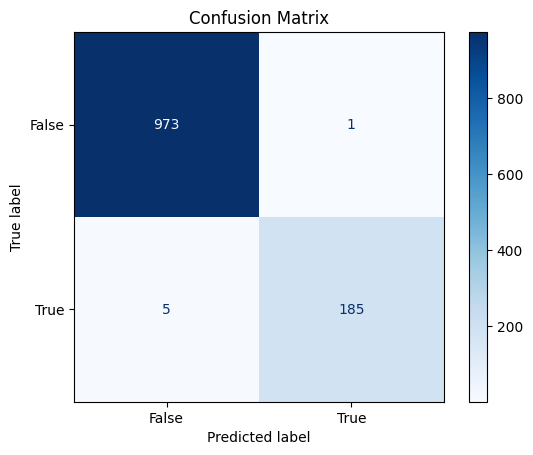

Results:
Classification-Report:
              precision    recall  f1-score   support

       False       0.99      1.00      1.00       974
        True       0.99      0.97      0.98       190

    accuracy                           0.99      1164
   macro avg       0.99      0.99      0.99      1164
weighted avg       0.99      0.99      0.99      1164


Confusion-Matrix: 
[[973   1]
 [  5 185]]

ROC-AUC-Score: 
0.9863

Accuracy-Score: 
0.9948


In [ ]:
logisticClassifier = LogisticRegression()

logisticClassifier.fit(X_train, (y_train==1))

y_pred = logisticClassifier.predict(X_train)
y_scores = logisticClassifier.predict_proba(X_train)[:,1]

plot_all(y_train, y_scores, y_pred, logisticClassifier.classes_)

#### Cross-Validation

In [ ]:
logisticClassifier = LogisticRegression(max_iter=1000)

print_cross_validation_metrics(logisticClassifier, X_reshape, y==1)

                  f1 : 0.8061538807256271
              recall : 0.7671985815602838
           precision : 0.8505184705714928
            accuracy : 0.9402579673304148
            f1_macro : 0.8854188571892555
        recall_macro : 0.8704845366817813
     precision_macro : 0.9031613227139399
         f1_weighted : 0.9389645298409184
     recall_weighted : 0.9402579673304148
  precision_weighted : 0.9387220366967448


### Neural Network

#### <label style='color:red'>Explicación de Red neuronal</label>

Es un modelo computacional inspirado en el funcionamiento del cerebro humano. Compuesta por nodos interconectados llamados neuronas, que trabajarn en conjunto par realizar tareas de aprendizaje automático, como clasificación, regresión o reconocimiento de patrones entre muchas.

- Neuronas :
    - Son las unidades básicas de procesamiento en una red neuronal. Cada neurona recibe entradas, realiza operaciones y manda una salida
    - Cada neurona tiene un conjunto de pesos asociados que determinan la importancia de las entradas en el cálculo de la salida
    - Las neuronas tiene una función de activación que deciden si deben mandar una señal de salida o no
- Capas : 
    - Las neuronas se organizan en capas en una red neuronal. La red puede tener más o menos capas intermedias, llamadas capas ocultas, además de una capa de entrada y salida.
    - En la capa de entrada, las neuronas reciben los datos de entrada y, en la de salida las neuronas producen la salida final de la red. En las capas intermedias la red procesa y transforma los datos de la entrada.
- Conexiones : 
    - Cada neurona está conectada a todas las neuronas de la siguiente capa. Estas conexiones están asociadas con pesos que determinan la fuerza de conexión entre neuronas
    - Durante el entrenamiento, los pesos se actualizan por algoritmos de optimización para minimizar la función de pérdida.
- Feedward y Retropropagación :
    - En la etapa de Feedward, las entradas se propagan a traves de las capas hasta la salida, provocando una predicción
    - En la capa de retropropagación, el error entre las predicciones del modelo y y las etiquetas verdadeas se propagan hacia atrás a través de la red. Los pesos de las conexiones se ajustan usando algoritmos como el descenso por gradiente

In [ ]:
# Aqui pasamos a one-hot encoding las etiquetas para poder diferenciar las 10 clases de las im'agenes
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

##### Hyperparam study

#### <label style='color:red'>Explicación del porqué de la estructura de la red</label>


In [ ]:
neuralModelo = Sequential([
    Dense(8, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])
neuralModelo.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
neuralModelo.summary()

x:\Repos\DMandML\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_82 (Dense)                │ (None, 64)             │       118,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ (None, 48)             │         3,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 10)             │           490 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 126,234 (493.10 KB)

 Trainable params: 126,234 (493.10 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = neuralModelo.fit(X_train, (y_train), epochs=1000, batch_size=64, validation_split=.2)

Epoch 1/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.2932 - loss: 2.0944 - val_accuracy: 0.3820 - val_loss: 1.9262
Epoch 2/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3586 - loss: 1.9710 - val_accuracy: 0.3863 - val_loss: 1.8919
Epoch 3/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3696 - loss: 1.9006 - val_accuracy: 0.3948 - val_loss: 1.8465
Epoch 4/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3702 - loss: 1.9105 - val_accuracy: 0.4077 - val_loss: 1.8215
Epoch 5/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3836 - loss: 1.8554 - val_accuracy: 0.4335 - val_loss: 1.7500
Epoch 6/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4190 - loss: 1.7540 - val_accuracy: 0.4807 - val_loss: 1.6650
Epoch 7/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4374 - loss: 1.6908 - val_accuracy: 0.4549 - val_loss: 1.6641
Epoch 8/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4721 - loss: 1.6103 - val_accuracy: 0

In [ ]:
y_pred_neural = neuralModelo.predict(X_test).astype(int)

print(f'Results:\nClassification-Report:\n{classification_report(y_test==1, y_pred_neural)}')
print(f'\nROC-AUC-Score: \n{roc_auc_score(y_test==1, y_pred_neural):.4f}')
print(f'\nAccuracy-Score: \n{accuracy_score(y_test==1, y_pred_neural):.4f}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Results:
Classification-Report:
              precision    recall  f1-score   support

           0       1.00      0.07      0.13        14
           1       0.92      0.72      0.80        46
           2       1.00      0.27      0.42        26
           3       0.99      0.66      0.79       106
           4       1.00      0.27      0.43        11
           5       0.86      0.35      0.50        17
           6       1.00      0.11      0.20         9
           7       0.00      0.00      0.00        18
           8       1.00      0.17      0.29        12
           9       1.00      0.12      0.22        33

   micro avg       0.96      0.43      0.60       292
   macro avg       0.88      0.27      0.38       292
weighted avg       0.91      0.43      0.55       292
 samples avg       0.43      0.43      0.43       292


ROC-AUC-Score: 
0.6361

Accuracy-Score: 
0.4349


x:\Repos\DMandML\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
x:\Repos\DMandML\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<label style='color:red'>Explicación de los resultados</label>

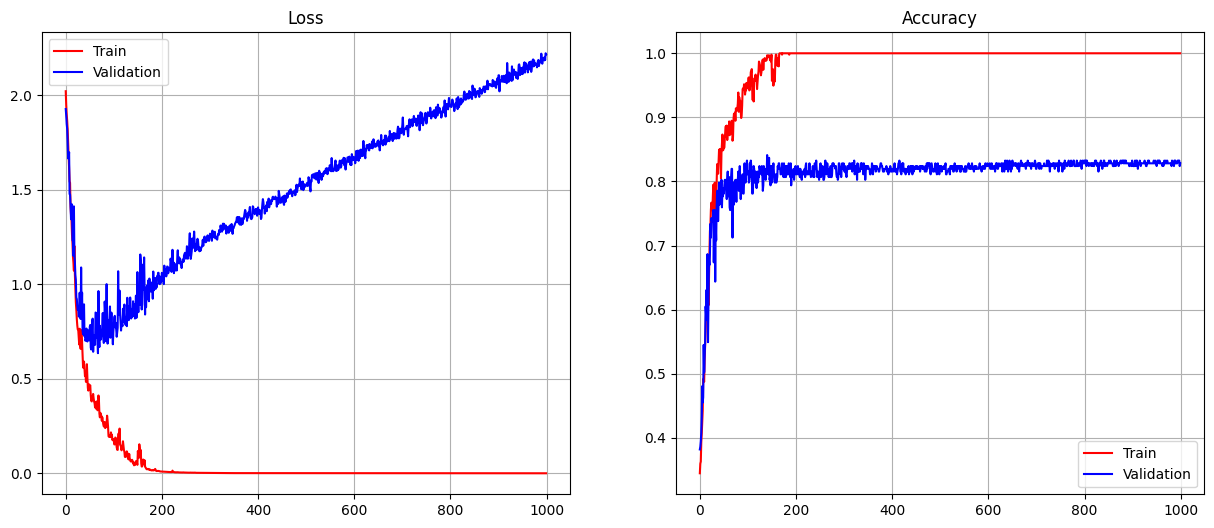

In [ ]:
plt.figure(figsize=(15,6))
# Subplot for loss 
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train', c='red')
plt.plot(history.history['val_loss'], label='Validation', c='blue')
plt.title('Loss')
plt.grid(True)
plt.legend()
# Subplot for accuracy
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train', c='red')
plt.plot(history.history['val_accuracy'], label='Validation', c='blue')
plt.title('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

<label style='color:red'>Explicación de la gráfica</label>

In [ ]:
acierto, fallo = 0,0

for a,b in zip(y_pred_neural, y_test):
    if(b[1]==1):
        #7print(a, '\t', b)
        if (a[1]==1):
            acierto +=1
        else:
            fallo += 1
print(f"Acierto (%total) = {acierto} ({acierto+fallo}) -->  {acierto/(acierto+fallo)*100:.4f}%")

Acierto (%total) = 33 (46) -->  71.7391%


### CNN

#### <label style='color:red'>Explicación de una red convolucional</label>

Es un tipo de red neuronal diseñada específicamente para procesar datos estructurados de forma cuadrática, como imágenes, 

- Convolución : 
    - Es la operación central de las CNN. Consiste en deslizar un pequeño filtro sobre la imagen de entrada y realizar una multiplicación elemento por elemento entre el filtro y la región de la imagen que está cubriendo. Luego sumamos estos productos.
    - Esta operación ayuda a la extracción de características locales de la imagen, como bordes, texturas y patrones en diferentes niveles de abstracción.
- Capas Convolucionales : 
    - Una CNN está compuesta principalmente por capas de convolución, que aplican múltiples filtros para extraer diferentes características de la imagen de entrada. 
    - Cada filtro produce un mapa de características  que resalta una específica de la imagen, como patrones, bordes o texturas.
-  Submuestreo ( Pooling ) : 
    - Después de la capa de convolución, podemos agregar capas de pooling para reducir la dimensionalidad de los mapas de características.
    - La operación de pooling reduce la dimensionalidad al tomar la operación ( max si maxpooling, min ... minpoolin, avg ... avgpoolin ) y aplicarla sobre una fracción del mapa de caracerísticas del mismo modo en que reazlizábamos la convolución
- Caaps completamente conectadas ( Dense ) :
    - Después de varias (o no) capas de convolución y pooling, la red puede tener una o varias capas Densas para realizar la clasificación final.
    - Estas toman las características extraídas por las capas anteriores y las combinan para producir una salida que presente las clases.
- Funciones de activación : 
    - En cada capa de la CNN se aplica una función de activación (normalmente la ReLu) después de la convolución y la operación de pooling para así introducir no linealidad en la red y permitir las representaciones complejas entre las características 

In [71]:
# Vamos a volver a cargar los datos para pasarlo a los tensores necesarios parar que funcione el algoritmo

lfw_people = fetch_lfw_people(min_faces_per_person=53, resize=.4)
X, y = lfw_people.images, lfw_people.target


In [72]:
# aplicamos un encoder sobre los labels
encoder = LabelEncoder()
y = encoder.fit_transform(y)

In [73]:
# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1164, 50, 37), (292, 50, 37), (1164,), (292,))

In [74]:
# Agregamos una dimension adicional para el canal de color (estamos originalmente en una escala de grises)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
X_train.shape, X_test.shape

((1164, 50, 37, 1), (292, 50, 37, 1))

In [75]:
# Cambiamos a one hot enconding las etiquetas
#y_train =   to_categorical(y_train==1)
#y_test =    to_categorical(y_test==1)

<label style='color:red'>Explicación del porqué de la forma de la CNN</label>

In [76]:
# Definimos el modelo
#
num_epochs = 1000
#
modeloCNN = Sequential([
    Conv2D(64, (3,3), activation='relu', input_shape=( X_train.shape[1], X_train.shape[2], 1) ),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
    ])
#
modeloCNN.summary()
#
modeloCNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#
earlyStop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
historyCNN = modeloCNN.fit(X_train, y_train==1, epochs=num_epochs, batch_size=64, validation_split=.25)

x:\Repos\DMandML\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_17 (Conv2D)              │ (None, 48, 35, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 24, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 26112)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 64)             │     1,671,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,676,097 (6.39 MB)

 Trainable params: 1,676,097 (6.39 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.8447 - loss: 0.4808 - val_accuracy: 0.8247 - val_loss: 0.4495
Epoch 2/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8387 - loss: 0.4233 - val_accuracy: 0.8247 - val_loss: 0.4144
Epoch 3/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.8351 - loss: 0.4001 - val_accuracy: 0.8247 - val_loss: 0.3755
Epoch 4/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8424 - loss: 0.3369 - val_accuracy: 0.8729 - val_loss: 0.3204
Epoch 5/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.8728 - loss: 0.2877 - val_accuracy: 0.8935 - val_loss: 0.2554
Epoch 6/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.8965 - loss: 0.2356 - val_accuracy: 0.9553 - val_loss: 0.1940
Epoch 7/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9430 - loss: 0.1775 - val_accuracy: 0.9725 - val_loss: 0.1553
Epoch 8/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9620 - loss: 0.1295 - val_accu

In [77]:
y_pred_CNN = modeloCNN.predict(X_test).astype(int)

print(f'Results:\nClassification-Report:\n{classification_report(y_test==1, y_pred_CNN)}')
print(f'\nROC-AUC-Score: \n{roc_auc_score(y_test==1, y_pred_CNN):.4f}')
print(f'\nAccuracy-Score: \n{accuracy_score(y_test==1, y_pred_CNN):.4f}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Results:
Classification-Report:
              precision    recall  f1-score   support

       False       0.91      1.00      0.96       246
        True       1.00      0.50      0.67        46

    accuracy                           0.92       292
   macro avg       0.96      0.75      0.81       292
weighted avg       0.93      0.92      0.91       292


ROC-AUC-Score: 
0.7500

Accuracy-Score: 
0.9212


<label style='color:red'>Explicación de resultados</label>

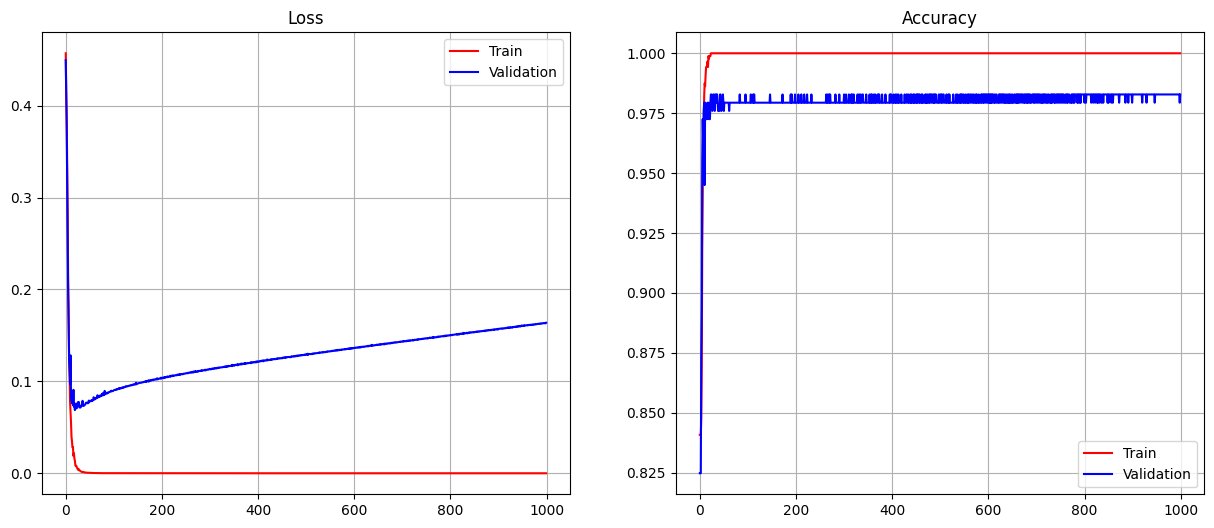

In [78]:

plt.figure(figsize=(15,6))
# Subplot for loss 
plt.subplot(1,2,1)
plt.plot(historyCNN.history['loss'], label='Train', c='red')
plt.plot(historyCNN.history['val_loss'], label='Validation', c='blue')
plt.title('Loss')
plt.grid(True)
plt.legend()
# Subplot for accuracy
plt.subplot(1,2,2)
plt.plot(historyCNN.history['accuracy'], label='Train', c='red')
plt.plot(historyCNN.history['val_accuracy'], label='Validation', c='blue')
plt.title('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

<label style='color:red'>Explicación de la gráfica</label>

In [79]:
acierto, fallo = 0, 0

for a,b in zip(y_pred_CNN, y_test):
    if(b==1):
        #7print(a, '\t', b)
        if (a==1):
            acierto +=1
        else:
            fallo += 1
print(f"Aciertos | Fallos (%total) = {acierto} | {fallo} ({acierto/(acierto+fallo)*100:.4f}%)")

Aciertos | Fallos (%total) = 23 | 23 (50.0000%)


# Model evaluation

In this section, we will discuss the results obtained with each model using the following methods:

- ### Resubstitution
En todas las pruebas que hemos tirado con resubstitution podemos afirmar que en la mayor parte de los casos tienen sino un 100%, un valor muy cercano debido a que estamos usando como datos de testing los mismos que hemos usado para el entrenamiento. 

Esta no es una práctica que debamos rechazar del todo ya que con esto podemos saber si nuestro algoritmo está funcionando como debe y no está malgastando recursos para nada.

No es una medida que podemos presentar como definitiva ya que sería como presentar un modelo sobreentrenado.

- ### Holdout 
Es el método que más usamos por separar un conjunto de datos en entrenamiento y testing, permitiendonos así diferenciar los datos y obtener resultados de testing reales de predicción

Es un método intermedio entre la simplicidad que nos ofrece la resubstitución y la complejidad computacional de la Cross-validation.

- ### Cross-validation
Este método suele ser computacionalmente costoso ya que, el que nosotros usamos (Kfold) consiste en separar un conjunto de datos en (K) trozos y realizamos un entrenamiento con (k-1) partes y dejamos la libre para la predicción. Este proceso lo repetimos las veces que hagan falta hasta que todas las partes estén probadas.

Este método a costa de ser más costoso tiene sus ventajas ya que como podemos observar en nuestros datos, este método proporciona una estimación más robusta y precisa del rendimiento de los modelos al promediar los resultados de varias evaluaciones.
Además, al final del método este habrá usado todos los datos tanto para entrenamiento como para testing.
